<h1>Classification</h1>

In [27]:
# from google.colab import drive
# drive.mount('/content/drive')

<h2 align="center">Random Forests</h2><h3>Parameters study</h3>

In [28]:
from numpy import array, ndarray
import numpy as np
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart

np.random.seed(42)

def undersample(X, y):
    indices_class_0 = np.where(y == 0)[0]
    indices_class_1 = np.where(y == 1)[0]
    num_samples_to_keep = len(indices_class_1)
    selected_indices_class_0 = np.random.choice(indices_class_0, num_samples_to_keep, replace=False)
    selected_indices = np.concatenate([selected_indices_class_0, indices_class_1])
    np.random.shuffle(selected_indices)
    X_undersampled = X[selected_indices]
    y_undersampled = y[selected_indices]
    return X_undersampled, y_undersampled

file_tag = "stroke"
train_filename = "./../../../data/class_covid_final_train.csv"
test_filename = "./../../../data/class_covid_final_test.csv"
target = "CovidPos"
eval_metric = "accuracy"

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)

trnX, trnY = undersample(trnX, trnY)

#trnX = trnX[:100]
#tstX = tstX[:100]
#trnY = trnY[:100]
#tstY = tstY[:100]
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")
print(len(trnY[trnY == 1]), len(trnY[trnY == 0]))

Train#=155228 Test#=114280
Labels=[0. 1.]
77614 77614


In [29]:
import numpy as np
from sklearn.model_selection import PredefinedSplit

fullX = np.concatenate([trnX, tstX])
fullY = np.concatenate([trnY, tstY])
test_fold = [-1] * len(trnX) + [0] * len(tstX)
cv = PredefinedSplit(test_fold)
for i, (train_index, test_index) in enumerate(cv.split()):
    print(f"Fold {i}")
    print(f"  Train: {len(train_index)=}")
    print(f"  Test: {len(test_index)=}")

Fold 0
  Train: len(train_index)=155228
  Test: len(test_index)=114280


In [30]:
nr_max_trees = 2500
lag = 500
n_estimators = list(range(1, nr_max_trees + 1, lag))
max_depths = [2, 5, 7]
max_features = [0.1, 0.3, 0.5, 0.7, 0.9]

param_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depths,
    "max_features": max_features
}
print(param_grid)

clf = RandomForestClassifier(n_jobs=4)
search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="accuracy", cv=cv, verbose=10, return_train_score=False)
#search.fit(fullX, fullY)

{'n_estimators': [1, 501, 1001, 1501, 2001], 'max_depth': [2, 5, 7], 'max_features': [0.1, 0.3, 0.5, 0.7, 0.9]}


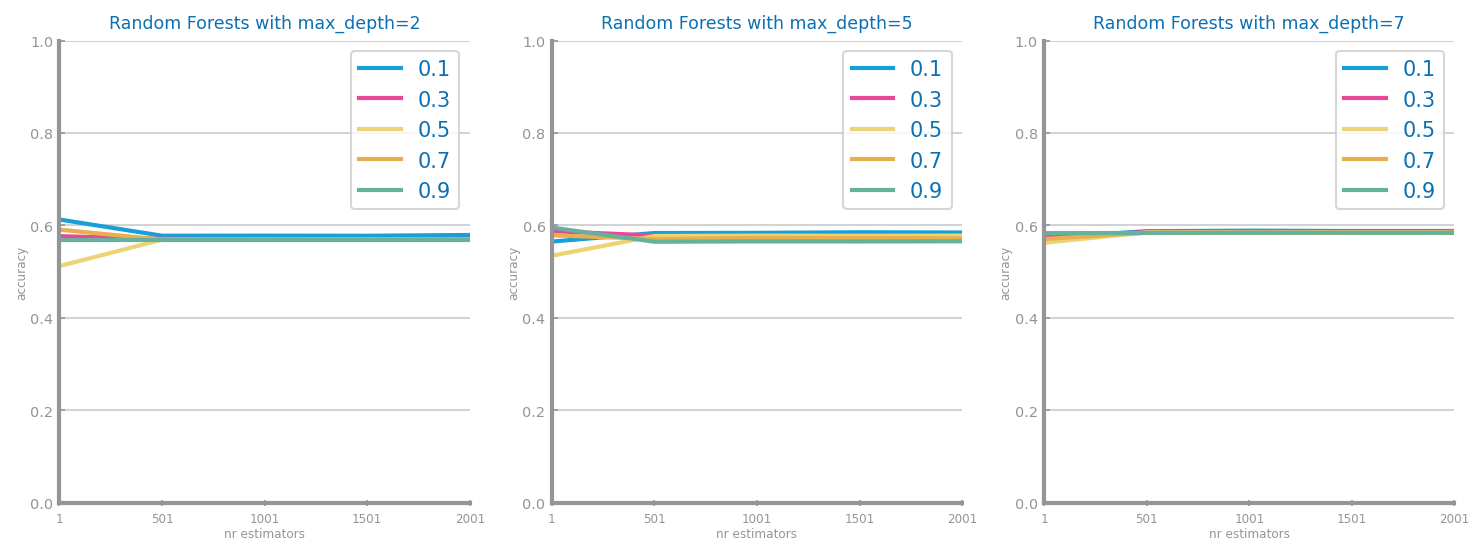

In [31]:
import pandas as pd

#results_df = pd.DataFrame(search.cv_results_)
#results_df.to_csv("./health_forests_results.csv")
results_df = pd.read_csv("./health_forests_results.csv")

cols: int = len(max_depths)
_, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
for i, max_depth in enumerate(max_depths):
  results = results_df[results_df["param_max_depth"] == max_depth]
  results = results[["param_max_features", "param_n_estimators", "split0_test_score" ]]

  values = {}
  for max_feature, group in results.groupby("param_max_features"):
    scores = [group[group["param_n_estimators"] == n_estimator]["split0_test_score"].values[0] for n_estimator in n_estimators]
    values[max_feature] = scores

  plot_multiline_chart(
      n_estimators,
      values,
      ax=axs[0, i],
      title=f"Random Forests with max_depth={max_depth}",
      xlabel="nr estimators",
      ylabel="accuracy",
      percentage=True,
  )

savefig(f"images/{file_tag}_rf_{eval_metric}_study.png", bbox_inches="tight")
show()

In [32]:
results_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,75.0,37.000000,21.794495,0.000000,18.500000,37.000000,55.500000,74.000000
mean_fit_time,75.0,54.779825,56.193680,0.069455,11.080874,36.265458,82.793314,240.518922
std_fit_time,75.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean_score_time,75.0,2.382260,1.768610,0.016128,0.956232,2.349999,3.830334,5.965170
std_score_time,75.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
param_max_depth,75.0,4.666667,2.068642,2.000000,2.000000,5.000000,7.000000,7.000000
param_max_features,75.0,0.500000,0.284747,0.100000,0.300000,0.500000,0.700000,0.900000
param_n_estimators,75.0,1001.000000,711.868497,1.000000,501.000000,1001.000000,1501.000000,2001.000000
split0_test_score,75.0,0.576254,0.012587,0.511769,0.569102,0.577721,0.584398,0.612609
mean_test_score,75.0,0.576254,0.012587,0.511769,0.569102,0.577721,0.584398,0.612609


In [42]:
best_model_index = results_df["split0_test_score"].idxmax()
print(results_df.loc[best_model_index])
best_params = results_df.loc[best_model_index]["params"]

print(best_params)
import ast
best_params = ast.literal_eval(best_params)
best_model = RandomForestClassifier(n_jobs=-1, n_estimators=500, max_depth=2, max_features=0.1)

Unnamed: 0                                                            0
mean_fit_time                                                  0.069455
std_fit_time                                                        0.0
mean_score_time                                                0.018212
std_score_time                                                      0.0
param_max_depth                                                       2
param_max_features                                                  0.1
param_n_estimators                                                    1
params                {'max_depth': 2, 'max_features': 0.1, 'n_estim...
split0_test_score                                              0.612609
mean_test_score                                                0.612609
std_test_score                                                      0.0
rank_test_score                                                       1
Name: 0, dtype: object
{'max_depth': 2, 'max_features': 0.1, 'n_

In [43]:
best_model.fit(trnX, trnY)

RandomForestClassifier(max_depth=2, max_features=0.1, n_estimators=500,
                       n_jobs=-1)

<Figure size 600x450 with 0 Axes>

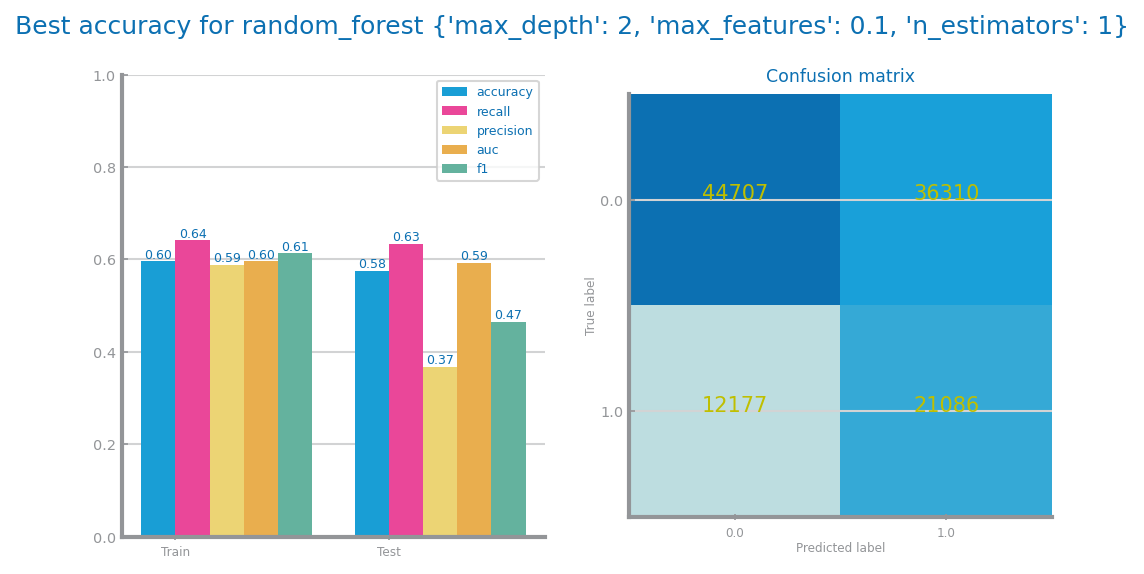

In [44]:

params = {"params": best_params, "metric": "accuracy", "name": "random_forest"}
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_rf_{params["name"]}_best_{params["metric"]}_eval.png')
show()

1. MentalHealthDays (0.5752861696371403)
2. ECigaretteUsage (0.3845794398096472)
3. Sex (0.040134390553212516)
4. FluVaxLast12 (0.0)
5. HighRiskLastYear (0.0)
6. TetanusLast10Tdap (0.0)
7. PneumoVaxEver (0.0)
8. BMI (0.0)
9. AlcoholDrinkers (0.0)
10. HIVTesting (0.0)
11. WeightInKilograms (0.0)
12. RaceEthnicityCategory (0.0)
13. ChestScan (0.0)
14. AgeCategory (0.0)
15. HeightInMeters (0.0)
16. DifficultyDressingBathing (0.0)
17. DifficultyWalking (0.0)
18. DifficultyConcentrating (0.0)
19. BlindOrVisionDifficulty (0.0)
20. DeafOrHardOfHearing (0.0)
21. HadDiabetes (0.0)
22. SmokerStatus (0.0)
23. DifficultyErrands (0.0)
24. HadKidneyDisease (0.0)
25. HadArthritis (0.0)
26. HadDepressiveDisorder (0.0)
27. HadCOPD (0.0)
28. HadStroke (0.0)
29. HadAngina (0.0)
30. HadSkinCancer (0.0)
31. HadAsthma (0.0)
32. RemovedTeeth (0.0)
33. HadHeartAttack (0.0)
34. PhysicalActivities (0.0)
35. SleepHours (0.0)
36. LastCheckupTime (0.0)
37. PhysicalHealthDays (0.0)
38. GeneralHealth (0.0)
39. State

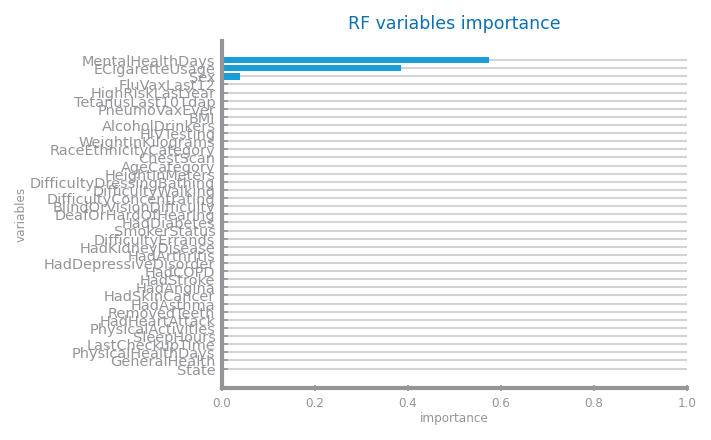

In [36]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
)
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_vars_ranking.png", bbox_inches="tight")

<h3>Overfitting study</h3>

In [37]:
d_max: int = params["params"][0]
feat: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_overfitting.png")

KeyError: 0